In [1]:
!pip install segmentation_models_pytorch_3d
!pip install torchmetrics

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd drive/

/content/drive


In [ ]:
### ONLY RUN ONCE
# # Step 2: Extract the ZIP into the proper folder
# import zipfile
# import os

# zip_path = "/content/drive/MyDrive/CSCI566/data/dl_data_final.zip"
# extract_path = "/content/drive/MyDrive/DL 3D Resnet Findings"

# # Create the extract directory if it doesn't exist
# os.makedirs(extract_path, exist_ok=True)

# # Unzip
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# print("✅ Extracted to:", extract_path)


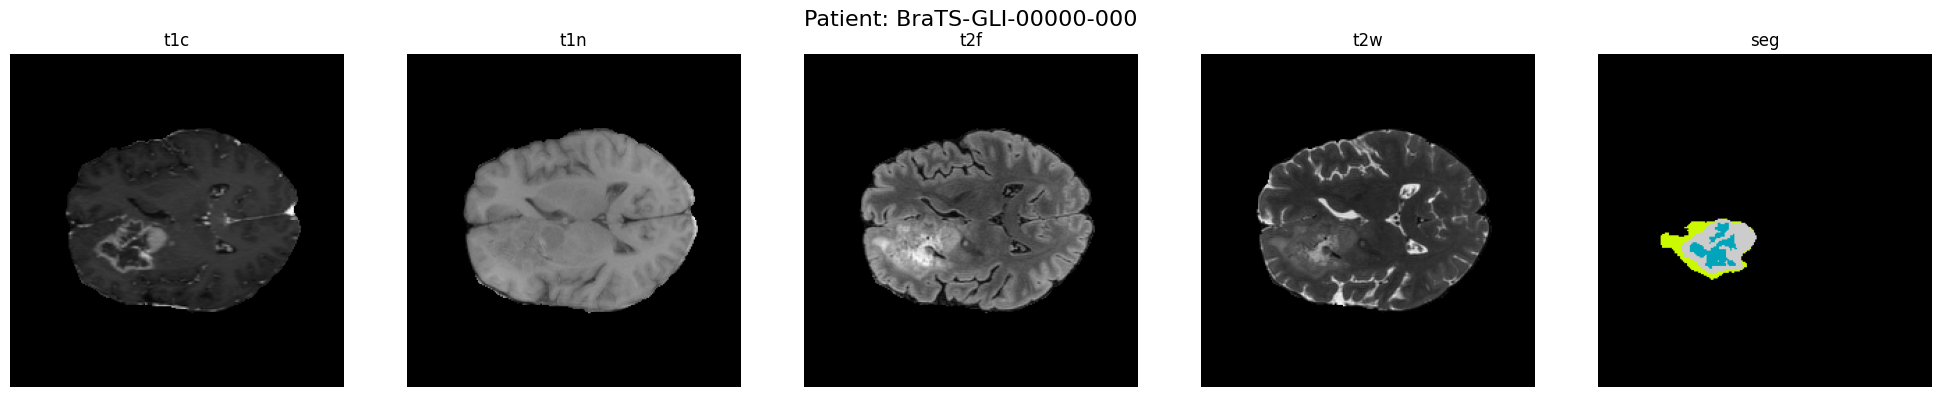

In [4]:
# Step 3: Analyze one patient from train/
import nibabel as nib
import matplotlib.pyplot as plt
import os

extract_path = "/content/drive/MyDrive/DL 3D Resnet Findings"

# Path to the extracted patient folder
patient_id = "BraTS-GLI-00000-000"
patient_path = os.path.join(extract_path, "dl_data_final", "train", patient_id)

# Modalities
modalities = ["t1c", "t1n", "t2f", "t2w", "seg"]
images = {}

# Load the modalities
for mod in modalities:
    file_path = os.path.join(patient_path, f"{patient_id}-{mod}.nii.gz")
    try:
        img = nib.load(file_path)
        images[mod] = img.get_fdata()
    except Exception as e:
        print(f"❌ Could not load {mod}: {e}")
        images[mod] = None

# Visualize axial mid-slice
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, mod in enumerate(modalities):
    ax = axes[i]
    img = images[mod]
    if img is not None:
        mid = img.shape[2] // 2
        cmap = "nipy_spectral" if mod == "seg" else "gray"
        ax.imshow(img[:, :, mid], cmap=cmap)
        ax.set_title(mod)
    else:
        ax.text(0.5, 0.5, "Load error", ha="center", va="center")
    ax.axis("off")

plt.suptitle(f"Patient: {patient_id}", fontsize=16)
plt.tight_layout()
plt.show()


# Validating Training Set
##(Making sure the data is clean and we do not have any bad inputs, ex NaN, Infs or Zeros values)



In [5]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import os

train_dir = "/content/drive/MyDrive/DL 3D Resnet Findings/dl_data_final/train"
modalities = ["t1c", "t1n", "t2f", "t2w", "seg"]

###0 Function to validate one patient
def validate_patient(patient_id):
    patient_path = os.path.join(train_dir, patient_id)
    shapes = []
    issues = []

    for mod in modalities:
        path = os.path.join(patient_path, f"{patient_id}-{mod}.nii.gz")
        if not os.path.exists(path):
            issues.append(f"{mod} missing")
            continue

        try:
            img = nib.load(path)
            data = img.get_fdata()

            # Shape check
            shapes.append(data.shape)

            # Data checks
            if np.isnan(data).any():
                issues.append(f"{mod} has NaNs")
            if np.isinf(data).any():
                issues.append(f"{mod} has Infs")
            if np.all(data == 0):
                issues.append(f"{mod} is all zeros")

            # Seg label check
            if mod == "seg":
                unique_vals = np.unique(data)
                if not np.all(np.isin(unique_vals, [0, 1, 2, 3])):  # Adjust if needed
                    issues.append(f"seg has invalid labels: {unique_vals}")

        except Exception as e:
            issues.append(f"Error loading {mod}: {e}")

    # Check shape consistency
    if len(set(shapes)) > 1:
        issues.append(f"Shape mismatch: {shapes}")

    return issues

In [ ]:
# Running takes about 1hr 30 mins. Validates if all patient scan details are fine. NO NEED TO RUN AGAIN
# Validating all patients
# patients = sorted([
#     f for f in os.listdir(train_dir)
#     if not f.startswith('.') and os.path.isdir(os.path.join(train_dir, f))
# ])

# print("🔍 Validating training data...\n")
# for pid in patients:
#     issues = validate_patient(pid)
#     if issues:
#         print(f"⚠️ {pid} has issues:")
#         for issue in issues:
#             print("   -", issue)
#     else:
#         print(f"✅ {pid} is clean")


# Pytorch Dataset and DataLoader


In [ ]:
### CODE FOR DELETING ALL .NPY FILES

# import os

# # Change this to your Drive path (e.g. inside MyDrive)
# root_dir = '/content/drive/MyDrive'

# # Loop through all files and delete .npy
# deleted = 0
# for dirpath, _, filenames in os.walk(root_dir):
#     for file in filenames:
#         if file.endswith('.npy'):
#             file_path = os.path.join(dirpath, file)
#             os.remove(file_path)
#             print(f"Deleted: {file_path}")
#             deleted += 1

# print(f"\n✅ Deleted {deleted} .npy files.")


In [6]:
import os
import torch
from torch.utils.data import Dataset
import nibabel as nib
import numpy as np

class BraTSDataset(Dataset):
    def __init__(self, root_dir, patient_ids, modalities=["t1c", "t1n", "t2f", "t2w"], crop_size=(128, 128, 128), transform=None):
        self.root_dir = root_dir
        self.patient_ids = patient_ids
        self.modalities = modalities
        self.crop_size = crop_size
        self.transform = transform

    def normalize(self, vol):
        mean = np.mean(vol)
        std = np.std(vol)
        return (vol - mean) / std if std != 0 else vol

    def center_crop(self, vol, crop_size):
        D, H, W = vol.shape
        cd, ch, cw = crop_size
        d_start = max((D - cd) // 2, 0)
        h_start = max((H - ch) // 2, 0)
        w_start = max((W - cw) // 2, 0)
        return vol[d_start:d_start+cd, h_start:h_start+ch, w_start:w_start+cw]

    def __len__(self):
        return len(self.patient_ids)

    def __getitem__(self, idx):
        pid = self.patient_ids[idx]
        patient_path = os.path.join(self.root_dir, pid)

        # Load and normalize each modality
        channels = []
        for mod in self.modalities:
            file_path = os.path.join(patient_path, f"{pid}-{mod}.nii.gz")
            img = nib.load(file_path).get_fdata()
            img = self.normalize(img)
            img = self.center_crop(img, self.crop_size)  # ✅ crop each modality
            channels.append(img)

        # Stack into [4, D, H, W]
        image = np.stack(channels, axis=0).astype(np.float32)

        # Load and crop segmentation mask [D, H, W]
        mask_path = os.path.join(patient_path, f"{pid}-seg.nii.gz")
        mask = nib.load(mask_path).get_fdata().astype(np.uint8)
        mask = self.center_crop(mask, self.crop_size)

        # Convert to tensors
        image = torch.from_numpy(image)
        mask = torch.from_numpy(mask)

        return image, mask

In [7]:
from torch.utils.data import DataLoader, random_split

# Path to raw .nii.gz dataset
train_path = "/content/drive/MyDrive/DL 3D Resnet Findings/dl_data_final/train"

# Get patient list
all_patients = sorted([
    f for f in os.listdir(train_path)
    if not f.startswith('.') and os.path.isdir(os.path.join(train_path, f))
])


# 80-20 train-val split
total_patients = len(all_patients)
split_index = int(0.8 * total_patients)

train_patients = all_patients[:split_index]
val_patients = all_patients[split_index:]

# Instantiate datasets
train_dataset = BraTSDataset(train_path, train_patients)
val_dataset = BraTSDataset(train_path, val_patients)

# DataLoaders (GPU-ready)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True, prefetch_factor=2)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)


# 3D ResNet Model

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock3D, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(out_channels)

        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm3d(out_channels)
            )

    def forward(self, x):
        identity = self.downsample(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return self.relu(out + identity)

class ResNet3DSeg(nn.Module):
    def __init__(self, in_channels=4, num_classes=4):
        super(ResNet3DSeg, self).__init__()
        self.enc1 = BasicBlock3D(in_channels, 32)
        self.enc2 = BasicBlock3D(32, 64, stride=2)
        self.enc3 = BasicBlock3D(64, 128, stride=2)
        self.enc4 = BasicBlock3D(128, 256, stride=2)

        self.up3 = nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2)
        self.dec3 = BasicBlock3D(128, 128)
        self.up2 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2)
        self.dec2 = BasicBlock3D(64, 64)
        self.up1 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2)
        self.dec1 = BasicBlock3D(32, 32)

        self.final = nn.Conv3d(32, num_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(x1)
        x3 = self.enc3(x2)
        x4 = self.enc4(x3)

        x = self.up3(x4)
        x = self.dec3(x)
        x = self.up2(x)
        x = self.dec2(x)
        x = self.up1(x)
        x = self.dec1(x)

        return self.final(x)


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet3DSeg(in_channels=4, num_classes=4).to(device)
model = torch.compile(model)

##1. Dice Loss Implementation

In [10]:
import torch.nn as nn
import torch.nn.functional as F

def center_crop_to_match(pred, target):
    _, _, Dp, Hp, Wp = pred.shape
    Dt, Ht, Wt = target.shape[1:]

    dz = (Dp - Dt) // 2
    dy = (Hp - Ht) // 2
    dx = (Wp - Wt) // 2

    return pred[:, :, dz:dz+Dt, dy:dy+Ht, dx:dx+Wt]

# class DiceCELoss(nn.Module):
#     def __init__(self, weight=None, smooth=1e-5):
#         super(DiceCELoss, self).__init__()
#         self.ce = nn.CrossEntropyLoss(weight=weight)
#         self.smooth = smooth

#     def forward(self, logits, target_onehot):
#         # logits: [B, C, D, H, W]
#         # target_onehot: [B, C, D, H, W]

#         ce_loss = self.ce(logits, torch.argmax(target_onehot, dim=1))  # Convert one-hot back to class indices for CE

#         probs = torch.softmax(logits, dim=1)
#         dims = (0, 2, 3, 4)  # Channel excluded

#         intersection = (probs * target_onehot).sum(dims)
#         union = probs.sum(dims) + target_onehot.sum(dims)

#         dice = (2. * intersection + self.smooth) / (union + self.smooth)
#         dice_loss = 1 - dice.mean()

#         return 0.5 * ce_loss + 0.5 * dice_loss

from segmentation_models_pytorch_3d.losses import DiceLoss, FocalLoss

# DiceLoss supports from_logits, FocalLoss does not
dice_loss = DiceLoss(mode='multiclass', from_logits=True)
focal_loss = FocalLoss(mode='multiclass')

def combined_loss(output, target):
    """
    output: logits from the model (B, C, D, H, W)
    target: one-hot encoded target (B, C, D, H, W)
    """
    return dice_loss(output, target) + focal_loss(output, target)



## 2. Training & Validation Loops

In [11]:
from tqdm import tqdm
from torch.amp import autocast, GradScaler
scaler = GradScaler(device='cuda')

# def train_one_epoch(model, dataloader, optimizer, criterion, device):
#     model.train()
#     running_loss = 0.0

#     for X, y in tqdm(dataloader, desc="🔁 Training", leave=False):
#         X, y = X.to(device), y.to(device)
#         target_onehot = F.one_hot(y.long(), num_classes=4).permute(0, 4, 1, 2, 3).float()

#         optimizer.zero_grad()
#         with autocast(device_type="cuda"):
#             outputs = model(X)
#             loss = criterion(outputs, target_onehot)

#         scaler.scale(loss).backward()
#         scaler.step(optimizer)
#         scaler.update()

#         running_loss += loss.item()

#     return running_loss / len(dataloader)

from torchmetrics.classification import MulticlassAccuracy
from torchmetrics import MeanMetric
import segmentation_models_pytorch_3d as smp_3d

def train_one_epoch(model, loader, optimizer, criterion, device, num_classes=4, epoch_idx=1, total_epochs=50):
    model.train()

    loss_record = MeanMetric().to(device)
    iou_record = MeanMetric().to(device)
    acc_record = MulticlassAccuracy(num_classes=num_classes, average='macro').to(device)

    loader_len = len(loader)

    with tqdm(total=loader_len, ncols=120) as tq:
        tq.set_description(f"Train :: Epoch {epoch_idx}/{total_epochs}")
        for X, y in loader:
            tq.update(1)
            X, y = X.to(device), y.to(device)
            y = y.long()  # ✅ Ensure label dtype is correct

            optimizer.zero_grad()

            with autocast(device_type="cuda"):
              outputs = model(X)
              outputs = center_crop_to_match(outputs, y)
              loss = criterion(outputs, y)  # ✅ Pass class indices directly

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            with torch.no_grad():
                preds = torch.argmax(outputs, dim=1)  # [B, D, H, W]

                tp, fp, fn, tn = smp_3d.metrics.get_stats(preds, y, mode='multiclass', num_classes=num_classes)
                iou_macro = smp_3d.metrics.iou_score(tp, fp, fn, tn, reduction='macro')

                acc_record.update(preds, y)  # both already on GPU
                loss_record.update(loss.detach().to(device), weight=X.shape[0])
                iou_record.update(iou_macro.to(device), weight=X.shape[0])

            tq.set_postfix_str(f"Loss: {loss_record.compute():.4f} | IoU: {iou_record.compute():.4f} | Acc: {acc_record.compute():.4f}")


    return loss_record.compute(), iou_record.compute(), acc_record.compute()





# def validate(model, dataloader, criterion, device):
#     model.eval()
#     running_loss = 0.0

#     with torch.no_grad():
#         for X, y in tqdm(dataloader, desc="📏 Validating", leave=False):
#             X, y = X.to(device), y.to(device)
#             target_onehot = F.one_hot(y.long(), num_classes=4).permute(0, 4, 1, 2, 3).float()

#             outputs = model(X)
#             loss = criterion(outputs, target_onehot)
#             running_loss += loss.item()

#     return running_loss / len(dataloader)

def validate(model, loader, criterion, device, num_classes=4):
    model.eval()

    loss_record = MeanMetric().to(device)
    iou_record = MeanMetric().to(device)
    acc_record = MulticlassAccuracy(num_classes=num_classes, average='macro').to(device)

    with torch.no_grad():
        for X, y in tqdm(loader, desc="📏 Validating", leave=False):
            X, y = X.to(device), y.to(device)
            y = y.long()

            outputs = model(X)
            outputs = center_crop_to_match(outputs, y)
            loss = criterion(outputs, y)

            preds = torch.argmax(outputs, dim=1)
            y_true = y  # already long and on device

            tp, fp, fn, tn = smp_3d.metrics.get_stats(preds, y_true, mode='multiclass', num_classes=num_classes)
            iou_macro = smp_3d.metrics.iou_score(tp, fp, fn, tn, reduction='macro')

            acc_record.update(preds, y_true)  # 🔁 Removed `.cpu()`
            loss_record.update(loss.detach().to(device), weight=X.shape[0])
            iou_record.update(iou_macro.to(device), weight=X.shape[0])  # 🔁 Removed `.cpu()`

    return loss_record.compute(), iou_record.compute(), acc_record.compute()



## 3. Train the Model

In [44]:
import os
from torch.optim import Adam

# Paths for checkpointing
checkpoint_path = "/content/drive/MyDrive/DL 3D Resnet Findings/checkpoint_latest.pth"
best_model_path = "/content/drive/MyDrive/DL 3D Resnet Findings/best_model.pth"

# Re-initialize model, optimizer, and AMP scaler
model = ResNet3DSeg(in_channels=4, num_classes=4).to(device)
criterion = combined_loss
optimizer = Adam(model.parameters(), lr=2e-4)
scaler = GradScaler(device='cuda')

# Resume from checkpoint if available
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scaler.load_state_dict(checkpoint['scaler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"🔁 Resuming training from epoch {start_epoch}")
else:
    #shows model architecture on first run
    start_epoch = 0
    print("🆕 Starting training from scratch")
    print(model)


🆕 Starting training from scratch
ResNet3DSeg(
  (enc1): BasicBlock3D(
    (conv1): Conv3d(4, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv3d(4, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
      (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (enc2): BasicBlock3D(
    (conv1): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn2): BatchNorm3d(

In [ ]:
import pickle

EPOCHS = 50
best_val_loss = float('inf')

# Initialize logs
train_losses, val_losses = [], []
train_ious, val_ious = [], []
train_accs, val_accs = [], []

for epoch in range(start_epoch, EPOCHS):
    print(f"\n => Epoch {epoch+1}/{EPOCHS}")

    # Training and Validation
    train_loss, train_iou, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device, epoch_idx=epoch+1, total_epochs=EPOCHS)
    val_loss, val_iou, val_acc = validate(model, val_loader, criterion, device)

    # Print metrics
    print(f" Train Loss: {train_loss:.4f} |  IoU: {train_iou:.4f} |  Accuracy: {train_acc:.4f}")
    print(f" Val   Loss: {val_loss:.4f} |  IoU: {val_iou:.4f} |  Accuracy: {val_acc:.4f}")

    # Store metrics
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    train_ious.append(train_iou.item())
    val_ious.append(val_iou.item())
    train_accs.append(train_acc.item())
    val_accs.append(val_acc.item())

    # Save latest checkpoint
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scaler_state_dict': scaler.state_dict()
    }
    torch.save(checkpoint, checkpoint_path)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_path = "/content/drive/MyDrive/DL 3D Resnet Findings/best_model.pth"
        torch.save(model.state_dict(), best_model_path)
        print("💾 Best model updated!")

# ✅ Save training logs after training is complete
logs = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "train_ious": train_ious,
    "val_ious": val_ious,
    "train_accs": train_accs,
    "val_accs": val_accs
}

with open("/content/drive/MyDrive/DL 3D Resnet Findings/train_logs.pkl", "wb") as f:
    pickle.dump(logs, f)

print("📁 Training logs saved to train_logs.pkl")



 => Epoch 1/50


Train :: Epoch 1/50: 100%|██████████████████| 808/808 [43:34<00:00,  3.24s/it, Loss: 0.5913 | IoU: 0.4697 | Acc: 0.5980]


 Train Loss: 0.5913 |  IoU: 0.4697 |  Accuracy: 0.5980
 Val   Loss: 0.4757 |  IoU: 0.5260 |  Accuracy: 0.7045
💾 Best model updated!

 => Epoch 2/50


Train :: Epoch 2/50: 100%|██████████████████| 808/808 [06:57<00:00,  1.94it/s, Loss: 0.3389 | IoU: 0.6214 | Acc: 0.7630]


 Train Loss: 0.3389 |  IoU: 0.6214 |  Accuracy: 0.7630
 Val   Loss: 0.4220 |  IoU: 0.5757 |  Accuracy: 0.7330
💾 Best model updated!

 => Epoch 3/50


Train :: Epoch 3/50: 100%|██████████████████| 808/808 [06:53<00:00,  1.95it/s, Loss: 0.2852 | IoU: 0.6679 | Acc: 0.8044]


 Train Loss: 0.2852 |  IoU: 0.6679 |  Accuracy: 0.8044
 Val   Loss: 0.4216 |  IoU: 0.5987 |  Accuracy: 0.6859
💾 Best model updated!

 => Epoch 4/50


Train :: Epoch 4/50: 100%|██████████████████| 808/808 [06:55<00:00,  1.94it/s, Loss: 0.2589 | IoU: 0.6918 | Acc: 0.8251]


 Train Loss: 0.2589 |  IoU: 0.6918 |  Accuracy: 0.8251
 Val   Loss: 0.3954 |  IoU: 0.6013 |  Accuracy: 0.7123
💾 Best model updated!

 => Epoch 5/50


Train :: Epoch 5/50: 100%|██████████████████| 808/808 [06:53<00:00,  1.95it/s, Loss: 0.2391 | IoU: 0.7110 | Acc: 0.8407]


 Train Loss: 0.2391 |  IoU: 0.7110 |  Accuracy: 0.8407
 Val   Loss: 0.3794 |  IoU: 0.6162 |  Accuracy: 0.7342
💾 Best model updated!

 => Epoch 6/50


Train :: Epoch 6/50: 100%|██████████████████| 808/808 [06:52<00:00,  1.96it/s, Loss: 0.2286 | IoU: 0.7204 | Acc: 0.8502]


 Train Loss: 0.2286 |  IoU: 0.7204 |  Accuracy: 0.8502
 Val   Loss: 0.7824 |  IoU: 0.5220 |  Accuracy: 0.7473

 => Epoch 7/50


Train :: Epoch 7/50: 100%|██████████████████| 808/808 [06:54<00:00,  1.95it/s, Loss: 0.2203 | IoU: 0.7298 | Acc: 0.8549]


 Train Loss: 0.2203 |  IoU: 0.7298 |  Accuracy: 0.8549
 Val   Loss: 0.3833 |  IoU: 0.6191 |  Accuracy: 0.7464

 => Epoch 8/50


Train :: Epoch 8/50: 100%|██████████████████| 808/808 [07:03<00:00,  1.91it/s, Loss: 0.2124 | IoU: 0.7362 | Acc: 0.8618]


 Train Loss: 0.2124 |  IoU: 0.7362 |  Accuracy: 0.8618
 Val   Loss: 0.3863 |  IoU: 0.6263 |  Accuracy: 0.7521

 => Epoch 9/50


Train :: Epoch 9/50: 100%|██████████████████| 808/808 [07:01<00:00,  1.91it/s, Loss: 0.2087 | IoU: 0.7385 | Acc: 0.8619]


 Train Loss: 0.2087 |  IoU: 0.7385 |  Accuracy: 0.8619
 Val   Loss: 0.4042 |  IoU: 0.6138 |  Accuracy: 0.7497

 => Epoch 10/50


Train :: Epoch 10/50: 100%|█████████████████| 808/808 [07:01<00:00,  1.92it/s, Loss: 0.1988 | IoU: 0.7485 | Acc: 0.8711]


 Train Loss: 0.1988 |  IoU: 0.7485 |  Accuracy: 0.8711
 Val   Loss: 0.3913 |  IoU: 0.6286 |  Accuracy: 0.7175

 => Epoch 11/50


Train :: Epoch 11/50: 100%|█████████████████| 808/808 [07:01<00:00,  1.92it/s, Loss: 0.1937 | IoU: 0.7551 | Acc: 0.8744]


 Train Loss: 0.1937 |  IoU: 0.7551 |  Accuracy: 0.8744
 Val   Loss: 0.3779 |  IoU: 0.6371 |  Accuracy: 0.7279
💾 Best model updated!

 => Epoch 12/50


Train :: Epoch 12/50: 100%|█████████████████| 808/808 [06:59<00:00,  1.93it/s, Loss: 0.1908 | IoU: 0.7587 | Acc: 0.8765]


 Train Loss: 0.1908 |  IoU: 0.7587 |  Accuracy: 0.8765
 Val   Loss: 0.3876 |  IoU: 0.6294 |  Accuracy: 0.7226

 => Epoch 13/50


Train :: Epoch 13/50: 100%|█████████████████| 808/808 [06:54<00:00,  1.95it/s, Loss: 0.1893 | IoU: 0.7593 | Acc: 0.8765]


 Train Loss: 0.1893 |  IoU: 0.7593 |  Accuracy: 0.8765
 Val   Loss: 0.3589 |  IoU: 0.6387 |  Accuracy: 0.7380
💾 Best model updated!

 => Epoch 14/50


Train :: Epoch 14/50: 100%|█████████████████| 808/808 [06:51<00:00,  1.96it/s, Loss: 0.1829 | IoU: 0.7625 | Acc: 0.8797]


 Train Loss: 0.1829 |  IoU: 0.7625 |  Accuracy: 0.8797
 Val   Loss: 0.3600 |  IoU: 0.6474 |  Accuracy: 0.7613

 => Epoch 15/50


Train :: Epoch 15/50: 100%|█████████████████| 808/808 [06:52<00:00,  1.96it/s, Loss: 0.1792 | IoU: 0.7688 | Acc: 0.8818]


 Train Loss: 0.1792 |  IoU: 0.7688 |  Accuracy: 0.8818
 Val   Loss: 0.3512 |  IoU: 0.6453 |  Accuracy: 0.7627
💾 Best model updated!

 => Epoch 16/50


Train :: Epoch 16/50: 100%|█████████████████| 808/808 [06:53<00:00,  1.95it/s, Loss: 0.1781 | IoU: 0.7685 | Acc: 0.8842]


 Train Loss: 0.1781 |  IoU: 0.7685 |  Accuracy: 0.8842
 Val   Loss: 0.4003 |  IoU: 0.6314 |  Accuracy: 0.7715

 => Epoch 17/50


Train :: Epoch 17/50:  45%|███████▋         | 365/808 [03:09<03:36,  2.04it/s, Loss: 0.1725 | IoU: 0.7761 | Acc: 0.8849]

In [30]:
## Saving the model

torch.save(model.state_dict(), "/content/drive/MyDrive/DL 3D Resnet Findings/3dresnet_model.pth")
print("✅ Model saved!")

✅ Model saved!


In [15]:
### testing the best_model

model.load_state_dict(torch.load("/content/drive/MyDrive/DL 3D Resnet Findings/best_model.pth"))
model.eval()

val_loss, val_iou, val_acc = validate(model, val_loader, criterion, device)
print("\n📊 Final Evaluation (Best Model):")
print(f"Val Loss  : {val_loss:.4f}")
print(f"Val IoU   : {val_iou:.4f}")
print(f"Val Acc   : {val_acc:.4f}")



📊 Final Evaluation (Best Model):
Val Loss  : 0.3273
Val IoU   : 0.6629
Val Acc   : 0.7854


In [16]:
### testing the final model after the 50 epochs

model.load_state_dict(torch.load("/content/drive/MyDrive/DL 3D Resnet Findings/3dresnet_model.pth"))
model.eval()

val_loss, val_iou, val_acc = validate(model, val_loader, criterion, device)
print("\n📊 Final Evaluation (Last Epoch Model):")
print(f"Val Loss  : {val_loss:.4f}")
print(f"Val IoU   : {val_iou:.4f}")
print(f"Val Acc   : {val_acc:.4f}")



📊 Final Evaluation (Last Epoch Model):
Val Loss  : 0.3557
Val IoU   : 0.6705
Val Acc   : 0.7583


In [27]:
model = ResNet3DSeg(in_channels=4, num_classes=4).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/DL 3D Resnet Findings/best_model.pth"))
model.eval()
print("✅ Model loaded and ready for inference!")

## In future if ever need to use it again, just do the following:
# model = ResNet3DSeg(in_channels=4, num_classes=4).to(device)
# model.load_state_dict(torch.load("/content/drive/MyDrive/DL 3D Resnet Findings/3dresnet_model.pth"))
# model.eval()
# with torch.no_grad():
#     for X, y in test_loader:  # or any new data
#         X = X.to(device)
#         output = model(X)
#         prediction = torch.argmax(output, dim=1)  # [B, D, H, W]


✅ Model loaded and ready for inference!


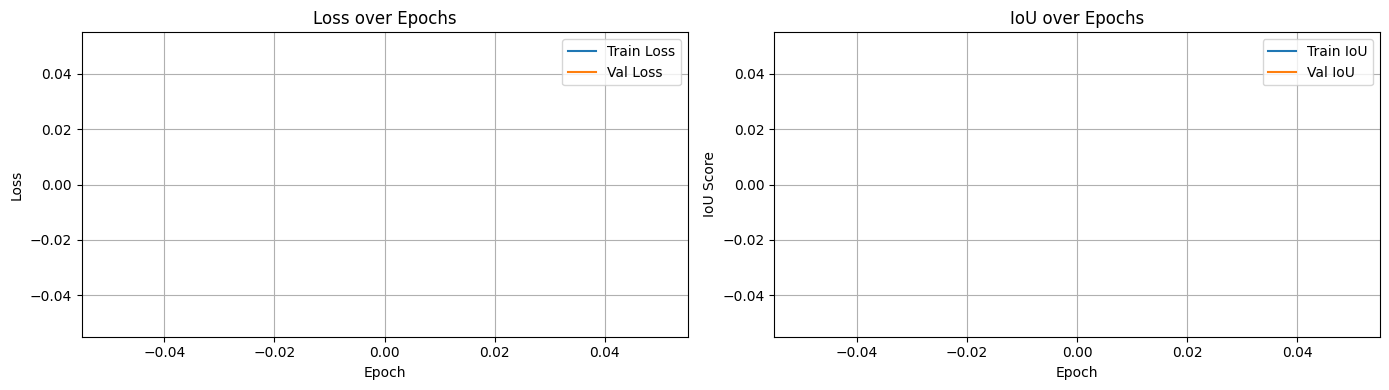

In [42]:
import matplotlib.pyplot as plt

epochs_range = range(start_epoch, EPOCHS)

plt.figure(figsize=(14, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Val Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Plot IoU
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_ious, label="Train IoU")
plt.plot(epochs_range, val_ious, label="Val IoU")
plt.title("IoU over Epochs")
plt.xlabel("Epoch")
plt.ylabel("IoU Score")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


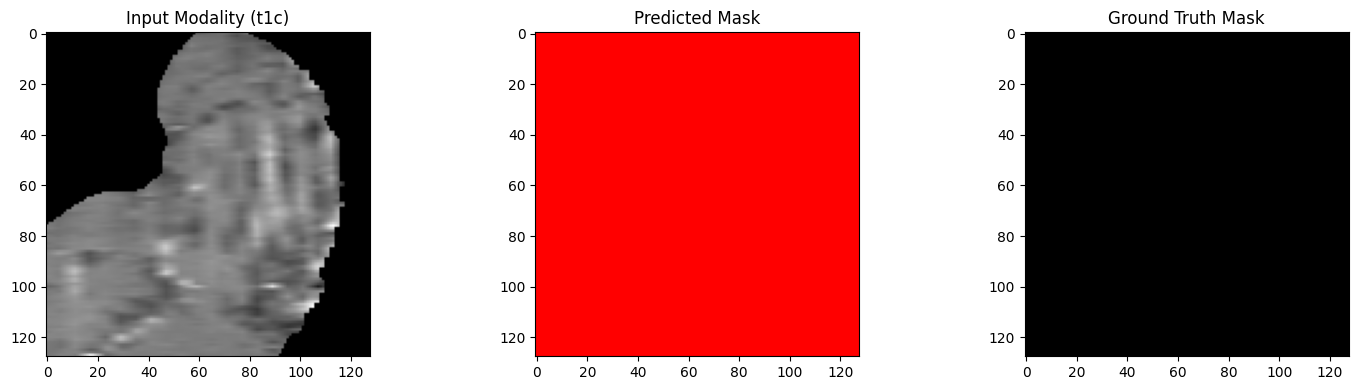

In [58]:
# After evaluation: add this block
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

model.eval()
sample_idx = random.randint(0, len(val_dataset) - 1)
X, y_true = val_dataset[sample_idx]
X = X.unsqueeze(0).to(device)
y_true = y_true.numpy()

with torch.no_grad():
    output = model(X)
    pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()

mid_slice = y_true.shape[0] // 2

cmap = colors.ListedColormap(['black', 'green', 'gray', 'red'])
bounds = [0, 1, 2, 3, 4]
norm = colors.BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.imshow(X[0, 0, mid_slice].cpu(), cmap="gray")
plt.title("Input Modality (t1c)")

plt.subplot(1, 3, 2)
plt.imshow(pred[mid_slice], cmap=cmap, norm=norm)
plt.title("Predicted Mask")

plt.subplot(1, 3, 3)
plt.imshow(y_true[mid_slice], cmap=cmap, norm=norm)
plt.title("Ground Truth Mask")
plt.tight_layout()
plt.show()


In [47]:
import torch.nn.functional as F

def to_one_hot(tensor, num_classes=4):
    """
    Converts tensor of shape [B, D, H, W] → one-hot shape [B, C, D, H, W]
    """
    one_hot = F.one_hot(tensor, num_classes=num_classes)  # [B, D, H, W, C]
    return one_hot.permute(0, 4, 1, 2, 3).float()          # [B, C, D, H, W]


# Evaluation on the Validation Set

### Add Utility for One-Hot Encoding

In [ ]:
import torch.nn.functional as F

def to_one_hot(tensor, num_classes=4):
    """Converts [B, D, H, W] → one-hot: [B, C, D, H, W]"""
    one_hot = F.one_hot(tensor, num_classes=num_classes)
    return one_hot.permute(0, 4, 1, 2, 3).float()


### Defining Metric Computation Function

In [ ]:
def compute_metrics(logits, target, num_classes=4, smooth=1e-5):
    """Compute Dice, IoU, Precision, Recall, F1 for each class using one-hot."""
    pred_labels = torch.argmax(logits, dim=1)  # shape: [B, D, H, W]
    pred_one_hot = F.one_hot(pred_labels, num_classes=num_classes).permute(0, 4, 1, 2, 3).float()
    target_one_hot = F.one_hot(target.long(), num_classes=num_classes).permute(0, 4, 1, 2, 3).float()

    metrics = {
        "dice": [],
        "iou": [],
        "precision": [],
        "recall": [],
        "f1": []
    }

    for c in range(num_classes):
        pred_c = pred_one_hot[:, c]   # shape: [B, D, H, W]
        target_c = target_one_hot[:, c]

        intersection = (pred_c * target_c).sum()
        union = pred_c.sum() + target_c.sum()
        TP = intersection
        FP = (pred_c * (1 - target_c)).sum()
        FN = ((1 - pred_c) * target_c).sum()

        dice = (2 * intersection + smooth) / (union + smooth)
        iou = (intersection + smooth) / (union - intersection + smooth)
        precision = (TP + smooth) / (TP + FP + smooth)
        recall = (TP + smooth) / (TP + FN + smooth)
        f1 = (2 * precision * recall) / (precision + recall + smooth)

        metrics["dice"].append(dice.item())
        metrics["iou"].append(iou.item())
        metrics["precision"].append(precision.item())
        metrics["recall"].append(recall.item())
        metrics["f1"].append(f1.item())

    return metrics


### Evaluating on Validation Set

In [ ]:
import numpy as np
from tqdm import tqdm

model.eval()
all_metrics = {
    "dice": [],
    "iou": [],
    "precision": [],
    "recall": [],
    "f1": []
}

with torch.no_grad():
    for X, y in tqdm(val_loader, desc=" Evaluating on Validation Set"):
        X, y = X.to(device), y.to(device)

        with autocast(device_type="cuda"):
            logits = model(X)  # [B, 4, D, H, W]

        logits = center_crop_to_match(logits, y)
        metrics = compute_metrics(logits, y)

        for key in all_metrics:
            all_metrics[key].append(metrics[key])

# Aggregate across validation set
for key in all_metrics:
    all_metrics[key] = np.mean(np.array(all_metrics[key]), axis=0)

# Report per class
class_names = ["Background", "Edema", "Non-enhancing", "Enhancing"]
for i in range(4):
    print(f"\n Class {i} - {class_names[i]}")
    print(f"    Dice:      {all_metrics['dice'][i]:.4f}")
    print(f"    IoU:       {all_metrics['iou'][i]:.4f}")
    print(f"    Precision: {all_metrics['precision'][i]:.4f}")
    print(f"    Recall:    {all_metrics['recall'][i]:.4f}")
    print(f"    F1 Score:  {all_metrics['f1'][i]:.4f}")

print(f"\ Mean Dice Score: {np.mean(all_metrics['dice']):.4f}")
print(f" Mean F1 Score:   {np.mean(all_metrics['f1']):.4f}")


 Evaluating on Validation Set:   0%|          | 0/101 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7adfec2d1b20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7adfec2d1b20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local


 Class 0 - Background
    Dice:      0.9991
    IoU:       0.9981
    Precision: 0.9989
    Recall:    0.9992
    F1 Score:  0.9991

 Class 1 - Edema
    Dice:      0.5901
    IoU:       0.4893
    Precision: 0.8558
    Recall:    0.5543
    F1 Score:  0.5901

 Class 2 - Non-enhancing
    Dice:      0.7502
    IoU:       0.6353
    Precision: 0.7296
    Recall:    0.8188
    F1 Score:  0.7502

 Class 3 - Enhancing
    Dice:      0.7628
    IoU:       0.6692
    Precision: 0.8151
    Recall:    0.7858
    F1 Score:  0.7628
\ Mean Dice Score: 0.7755
 Mean F1 Score:   0.7755


# Evaluate the Model on the Test Set

##  Setup Test Dataset & DataLoader

In [ ]:
test_path = "/content/drive/MyDrive/DL 3D Resnet Findings/dl_data_final/test"

test_patients = sorted([
    f for f in os.listdir(test_path)
    if not f.startswith('.') and os.path.isdir(os.path.join(test_path, f))
])

test_dataset = BraTSDataset(test_path, test_patients)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)


## Dice Score Function (Inference version)

In [ ]:
def compute_dice_score(pred, target, num_classes=4, smooth=1e-5):
    pred = torch.argmax(pred, dim=1)  # [B, D, H, W]
    scores = []

    for cls in range(num_classes):
        pred_cls = (pred == cls).float()
        target_cls = (target == cls).float()

        intersection = (pred_cls * target_cls).sum()
        union = pred_cls.sum() + target_cls.sum()
        dice = (2 * intersection + smooth) / (union + smooth)
        scores.append(dice.item())

    return scores  # List of dice scores per class


## Run Inference on Test Set

In [ ]:
model.eval()
all_scores = []

with torch.no_grad():
    for X, y in tqdm(test_loader, desc="🧪 Evaluating on Test Set"):
        X, y = X.to(device), y.to(device)

        with autocast(device_type="cuda"):
            logits = model(X)

        logits = center_crop_to_match(logits, y)  # ensure output shape matches mask
        scores = compute_dice_score(logits, y)
        all_scores.append(scores)

# Results
import numpy as np
all_scores = np.array(all_scores)
mean_dice_per_class = np.mean(all_scores, axis=0)

for i, dice in enumerate(mean_dice_per_class):
    print(f"🎯 Dice Score (Class {i}): {dice:.4f}")

print(f"\n🧠 Mean Dice Score across all classes: {np.mean(mean_dice_per_class):.4f}")
